<a href="https://colab.research.google.com/github/vishenka-git/openCV/blob/master/Body_Torso_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [2]:
!mkdir body_train

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#!ls "/content/gdrive/My Drive"

In [5]:
!unzip -q "/content/gdrive/My Drive/bodies.zip" -d body_train

In [6]:
pip install opencv-python

In [7]:
import cv2
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
font = cv2.FONT_HERSHEY_SIMPLEX

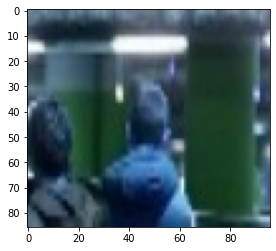

In [28]:
import glob
import numpy as np
import pprint

X_data = { 'data': None, 'target': None, 'target_name': None }

# iterate through the target directory (recursively) finding .jpg files
target_dir = "/content/body_train/dataset/train"
files = []
for f in glob.glob(target_dir + '/**/*', recursive=True):
    if f[-4:] == '.jpg':
        files.append(f)
#print('files=', files)

# create separate lists to store the data
data_list = []
target_list = []
target_name_list = []

# iterate through the files
for filename in files:
    # load input image
    image = cv2.imread(filename)
    #print('f=', filename)

    # remove the target folder name from the path
    subdir_plus_file = filename[len(target_dir)+1:]
    #print('subdir_plus_file=', subdir_plus_file)

    # extract the subdirectory
    slash_idx = subdir_plus_file.index('/')
    if (slash_idx):
        subdir = subdir_plus_file[:slash_idx]
    else:
        subdir = 'None'
    #print('subdir=', subdir)

    # append each piece of data into its respective list
    data_list.append(image)
    target_list.append(filename)
    target_name_list.append(subdir)

# convert each list into a np.array and then assemble them into a single data structure (dictionary)
X_data['data'] = np.array(data_list)
X_data['target'] = np.array(target_list)
X_data['target_name'] = np.array(target_name_list)

# print the dictionary contents
#pprint.pprint(X_data, depth=1)

# display each image along with its respective target and target_name
for idx, _ in enumerate(X_data['target']):
  image = X_data['data'][idx] 
  plt.imshow(image)
  #print('File #' , idx, '  target=', X_data['target'][idx], '  target_name=', X_data['target_name'][idx])
  cv2.waitKey(0)

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import os

callback = [EarlyStopping(monitor='loss', patience=0, verbose=1)]

classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Flatten())

classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing model

from keras.utils import plot_model
plot_model(classifier, to_file='model.png', show_shapes=True)

# Processing images

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True)

train_data_dir = '/content/body_train/dataset/train/'
test_data_dir = '/content/body_train/dataset/testing_set_people/'

test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(train_data_dir,
 target_size=(64, 64),
 batch_size=32,
 class_mode='binary')
test_set = test_datagen.flow_from_directory(test_data_dir,
 target_size=(64, 64),
 batch_size=32,
 class_mode='binary')

classifier.fit_generator(training_set,
 steps_per_epoch=4000,
 epochs=5,
 validation_data=test_set,
 validation_steps=1000,
 callbacks=callback)

Using TensorFlow backend.


Found 17120 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.
Epoch 1/5
4000/4000 [==============================] - 736s 184ms/step - loss: 0.1704 - accuracy: 0.9337 - val_loss: 0.6580 - val_accuracy: 0.6682
Epoch 2/5
4000/4000 [==============================] - 734s 183ms/step - loss: 0.0764 - accuracy: 0.9713 - val_loss: 0.7190 - val_accuracy: 0.7943
Epoch 3/5
4000/4000 [==============================] - 733s 183ms/step - loss: 0.0459 - accuracy: 0.9830 - val_loss: 0.8081 - val_accuracy: 0.8116
Epoch 4/5
4000/4000 [==============================] - 739s 185ms/step - loss: 0.0310 - accuracy: 0.9891 - val_loss: 0.6977 - val_accuracy: 0.8248
Epoch 5/5
4000/4000 [==============================] - 731s 183ms/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 1.0401 - val_accuracy: 0.8187


OSError: ignored

In [30]:
model_name = 'Bodies.h5'
save_dir = '/content/body_train/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
classifier.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/body_train/Bodies.h5 


In [38]:
 import keras
# import cv2
# import numpy as np

class Predict:

    def __init__(self, path, file):

        self.path = path
        self.file = file

    def load_model(self):
        '''
        I am here to load you model.
        '''
        self.loaded_model = keras.models.load_model(self.path)
        return self.loaded_model

    def makepredictions(self):
        '''
        I am here to process the files, create your features and make predictions
        '''

        img = cv2.imread(self.file)
        img = cv2.resize(img, (64, 64))
        img = np.reshape(img, [1, 64, 64, 3])
        print("File loaded and reshaped. The new shape is ", img.shape)
        print("Start predicting...")
        predictions = self.loaded_model.predict_classes(img)

        # Converting output to human readable labels

        if predictions == 0:
            predictions = 'rubbish'
        elif predictions == 1:
            predictions = 'body'

        print( "Prediction completed: this is a", predictions)

# Below you should change the variable as follows:
# the `PATH` variable should be the local path in which you have downloaded the model `Bodies.h5`
# the `FILE` variable should be the path to the example file `test.jpeg` (or any other file of Upper or Lower Torso you want to use).

pred = Predict(
    path='/content/body_train/Bodies.h5',
    file='/content/body_train/dataset/testing_set_people/neg/10.jpg')

pred.load_model()
pred.makepredictions()

File loaded and reshaped. The new shape is  (1, 64, 64, 3)
Start predicting...
Prediction completed: this is a rubbish


In [ ]:
test_image = cv2.imread('/content/body_train/dataset/train/pos/2019-05-09_103442768087_0.jpg')

In [ ]:
test_image

array([[[ 25,  39,  33],
        [ 24,  38,  32],
        [ 23,  38,  34],
        ...,
        [ 35,  47,  41],
        [ 38,  49,  46],
        [ 61,  72,  69]],

       [[ 22,  36,  30],
        [ 19,  33,  27],
        [ 11,  26,  22],
        ...,
        [ 24,  36,  30],
        [ 14,  25,  22],
        [ 33,  44,  41]],

       [[ 20,  34,  28],
        [ 18,  32,  26],
        [ 11,  26,  22],
        ...,
        [ 31,  42,  34],
        [ 27,  37,  31],
        [ 23,  33,  27]],

       ...,

       [[  9,  35,  22],
        [ 33,  63,  50],
        [ 94, 130, 116],
        ...,
        [ 11,  12,   2],
        [ 10,  14,   3],
        [ 33,  40,  27]],

       [[  0,  13,   4],
        [ 27,  51,  41],
        [103, 135, 124],
        ...,
        [ 11,  15,   4],
        [  4,  10,   0],
        [  6,  15,   2]],

       [[  1,  18,   9],
        [ 34,  55,  46],
        [118, 148, 137],
        ...,
        [ 10,  16,   5],
        [  6,  12,   1],
        [  1,  10,   0]]

In [ ]:
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

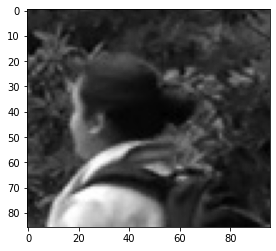

In [ ]:
plt.imshow(test_image_gray, cmap='gray')

In [ ]:
print(test_image_gray.shape)

(86, 96)


In [ ]:
# def convertToRGB(image):
#     return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
path = ''
pos_train_data_dir = path + '/content/body_train/dataset/train/pos'
neg_train_data_dir = path + '/content/body_train/dataset/train/neg'
#validation_data_dir = path + "data/validation"
test_data_dir = path + "/content/body_train/dataset/testing_set_people"

In [ ]:
main_dir = "/content/body_train/dataset/"
train_dir = "/content/body_train/dataset/train"
path = os.path.join(main_dir,train_dir)
test_dir = "/content/body_train/dataset/testing_set_people"

In [ ]:
X = []
for fn in pos_train_data_dir:
  if fn.endswith('.jpg'):
    img_array = cv2.imread(fn)
    img_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    new_img_array = cv2.resize(img_gray, dsize=(80, 80))
    X.append(new_img_array)
  else:
    continue

In [ ]:
import cv2
import glob
import numpy as np
import pprint

X_data = { 'data': None, 'target': None, 'target_name': None }

# iterate through the target directory (recursively) finding .jpg files
target_dir = ''
files = []
for f in glob.glob(target_dir + '/**/*', recursive=True):
    if f[-4:] == '.jpg':
        files.append(f)
#print('files=', files)

/
c
o
n
t
e
n
t
/
b
o
d
y
_
t
r
a
i
n
/
d
a
t
a
s
e
t
/
t
r
a
i
n
/
p
o
s


In [ ]:
test_img = cv2.imread('/content/body_train/dataset/testing_set_people/neg/10.jpg')
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
new_img_arr = cv2.resize(test_img_gray, dsize=(80, 80))
new_img_arr

array([[  0,   0,   0, ..., 254, 254, 253],
       [  0,   0,   0, ..., 254, 254, 253],
       [  0,   0,   0, ..., 254, 254, 253],
       ...,
       [  0,   0,   0, ..., 254, 254, 254],
       [  0,   0,   0, ..., 254, 254, 254],
       [  0,   0,   0, ..., 254, 254, 254]], dtype=uint8)

In [ ]:
 for p in os.listdir(path):
   category = p.split(".")[0]
   print(category)

neg
pos


In [ ]:
import glob 
for p in glob.glob('**/*.jpg', recursive=True):
     #if f.endswith('.jpg'):
      print(p)

Выходные данные были обрезаны до нескольких последних строк (5000).
body_train/dataset/train/pos/2019-06-23_181851422093_0.jpg
body_train/dataset/train/pos/2019-05-17_080556273748_0.jpg
body_train/dataset/train/pos/2019-05-17_091741400594_1.jpg
body_train/dataset/train/pos/2019-05-17_095926749366_0.jpg
body_train/dataset/train/pos/2019-05-17_093112102291_1.jpg
body_train/dataset/train/pos/2019-06-23_181839893254_3.jpg
body_train/dataset/train/pos/2019-06-23_182729032428_1.jpg
body_train/dataset/train/pos/2019-05-17_100225839657_1.jpg
body_train/dataset/train/pos/2019-05-17_091642417652_0.jpg
body_train/dataset/train/pos/2019-05-17_080552743829_0.jpg
body_train/dataset/train/pos/2019-05-17_081531839038_1.jpg
body_train/dataset/train/pos/2019-05-17_093534631432_0.jpg
body_train/dataset/train/pos/2019-06-23_182749609371_1.jpg
body_train/dataset/train/pos/2019-06-23_182802414931_0.jpg
body_train/dataset/train/pos/2019-06-23_181912994219_0.jpg
body_train/dataset/train/pos/2019-05-17_0817355

In [ ]:
os.listdir()

['.config',
 'gdrive',
 '.ipynb_checkpoints',
 'drive',
 'body_train',
 'sample_data']

In [ ]:
category

'pos'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
# training_data_dir = path + "data/training" # 10 000 * 2
# validation_data_dir = path + "data/validation" # 2 500 * 2
# test_data_dir = path + "data/test" # 12 500

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
#validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(86, 96),
    batch_size=32,
    class_mode="binary")
# validation_generator = validation_data_generator.flow_from_directory(
#     validation_data_dir,
#     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
#     batch_size=BATCH_SIZE,
#     class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(86, 96),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 17120 images belonging to 2 classes.
Found 1088 images belonging to 2 classes.


In [ ]:
train_generator

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

NameError: ignored